In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

from kneed import KneeLocator
from scipy.stats import mstats
from sklearn.cluster import KMeans

In [2]:
#lets read the csv file
df = pd.read_csv("SP500_ROA_RPS.csv", index_col = 0)
df.head()

,ROA,RPS
ticker,,
SNPS,0.05847,26.727
A,0.08347,20.072
CBOE,0.07177,32.019
HBAN,0.00774,4.495
SJM,0.04814,71.065


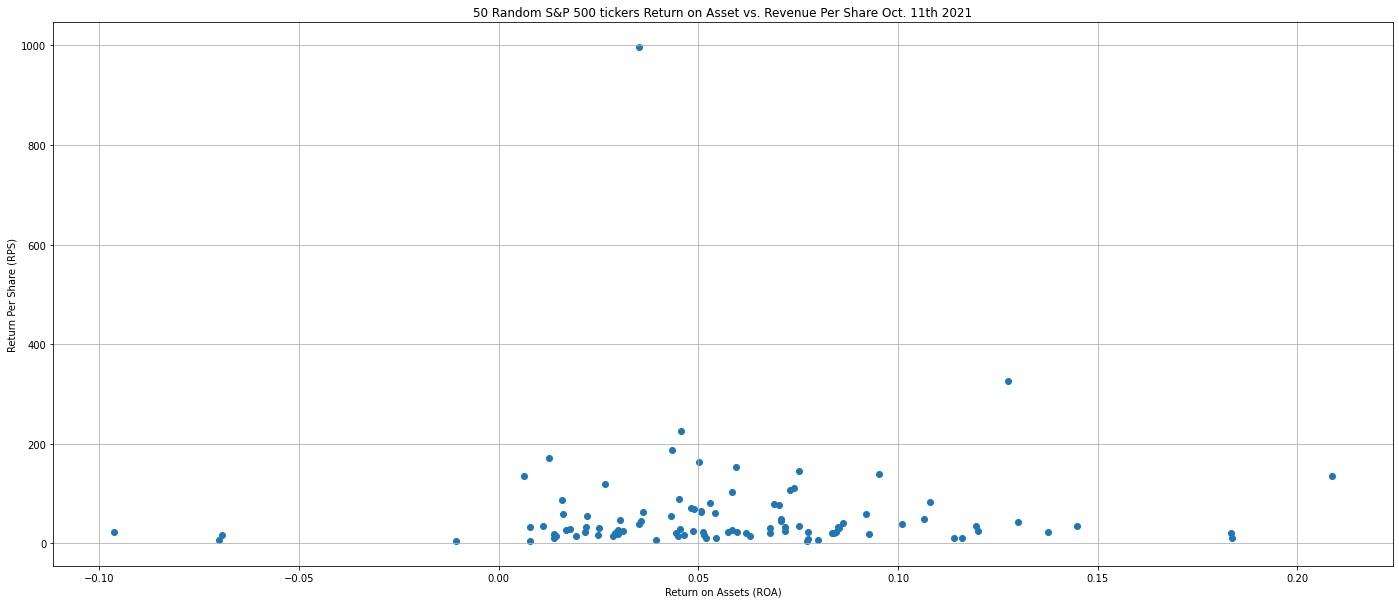

In [3]:
plt.figure(figsize = (24,10))
plt.grid(True)
plt.scatter(df['ROA'], df['RPS'])
plt.title("50 Random S&P 500 tickers Return on Asset vs. Revenue Per Share Oct. 11th 2021")
plt.xlabel("Return on Assets (ROA)")
plt.ylabel("Return Per Share (RPS)")
plt.show()

In [4]:
#the statistics are scaled to the company's size
df['ROA'] = mstats.winsorize(df['ROA'], limits = [0.05, 0.05])
df['RPS'] = mstats.winsorize(df['RPS'], limits = [0.05, 0.05])
df.head()

,ROA,RPS
ticker,,
SNPS,0.05847,26.727
A,0.08347,20.072
CBOE,0.07177,32.019
HBAN,0.00774,6.828
SJM,0.04814,71.065


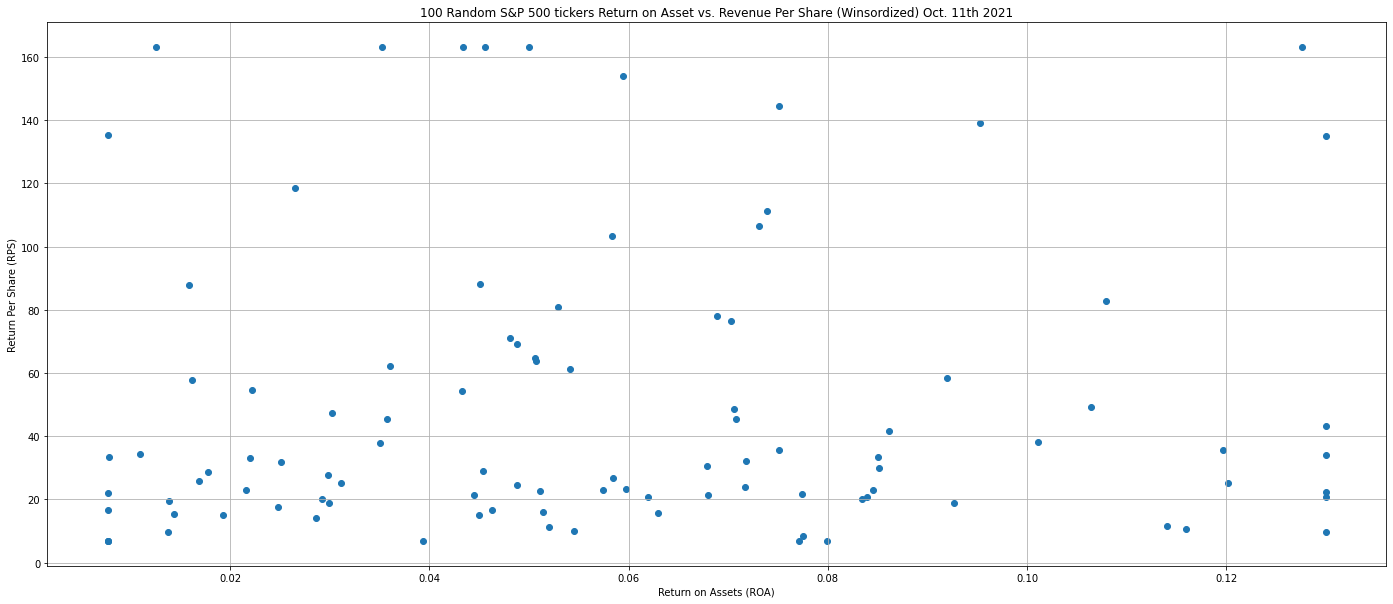

In [5]:
plt.figure(figsize = (24,10))
plt.grid(True)
plt.scatter(df['ROA'], df['RPS'])
plt.title("100 Random S&P 500 tickers Return on Asset vs. Revenue Per Share (Winsordized) Oct. 11th 2021")
plt.xlabel("Return on Assets (ROA)")
plt.ylabel("Return Per Share (RPS)")
plt.show()

In [6]:
distorsions = []
clusters_iterations = range(2,20)

for k in clusters_iterations:
    
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df)
    distorsions.append(kmeans.inertia_)
    
elbow_curve = pd.DataFrame(zip(clusters_iterations, distorsions), columns = ['Cluster', 'SSE']).set_index('Cluster')
elbow_curve.head()

,SSE
Cluster,
2,43663.768606
3,16708.567974
4,9703.836563
5,6300.847265
6,4485.122886


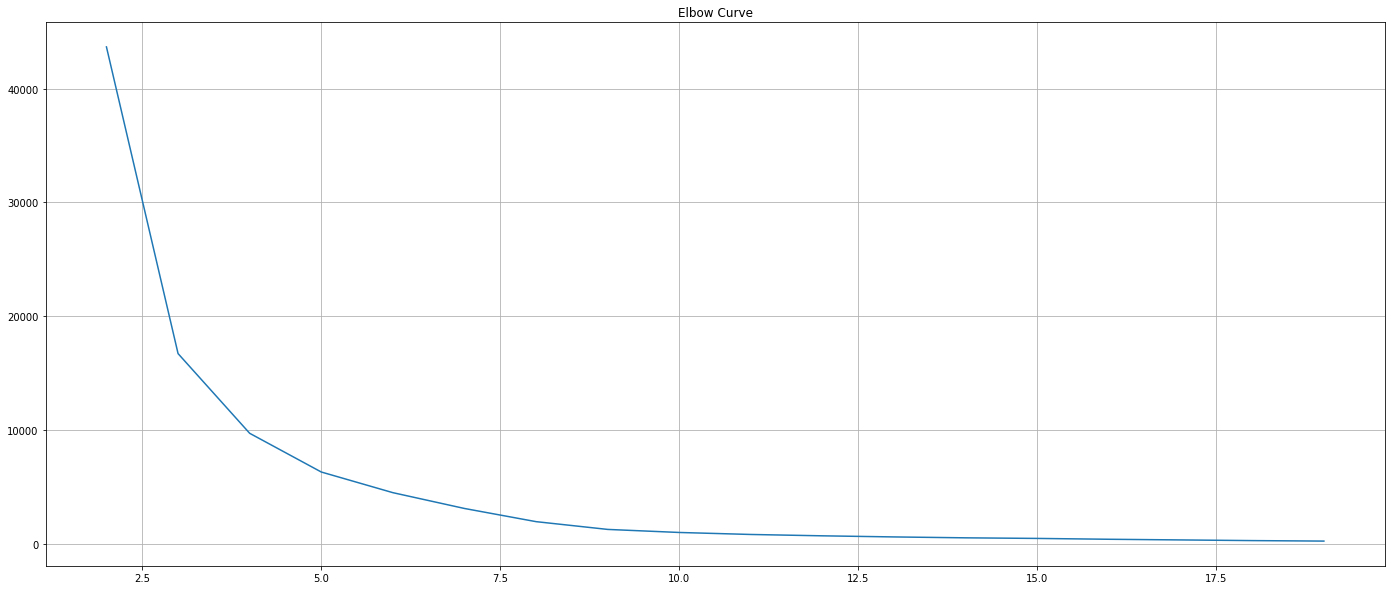

In [7]:
plt.figure(figsize = (24,10))
plt.plot(elbow_curve['SSE'])
plt.title("Elbow Curve")
plt.grid(True)
plt.show()

In [8]:
#this will find the optimal kmeans
kl = KneeLocator(clusters_iterations, distorsions, curve = "convex", direction = "decreasing")
elbow = kl.elbow
print(kl.elbow)

5


In [9]:
kmeans = KMeans(n_clusters = elbow)
kmeans.fit(df)
y_kmeans = kmeans.predict(df)
df_kmeans = df.copy()
df_kmeans['cluster'] = y_kmeans.astype(str)

Text(0.5, 1.0, 'KMeans clustering for ROA vs. RPS')

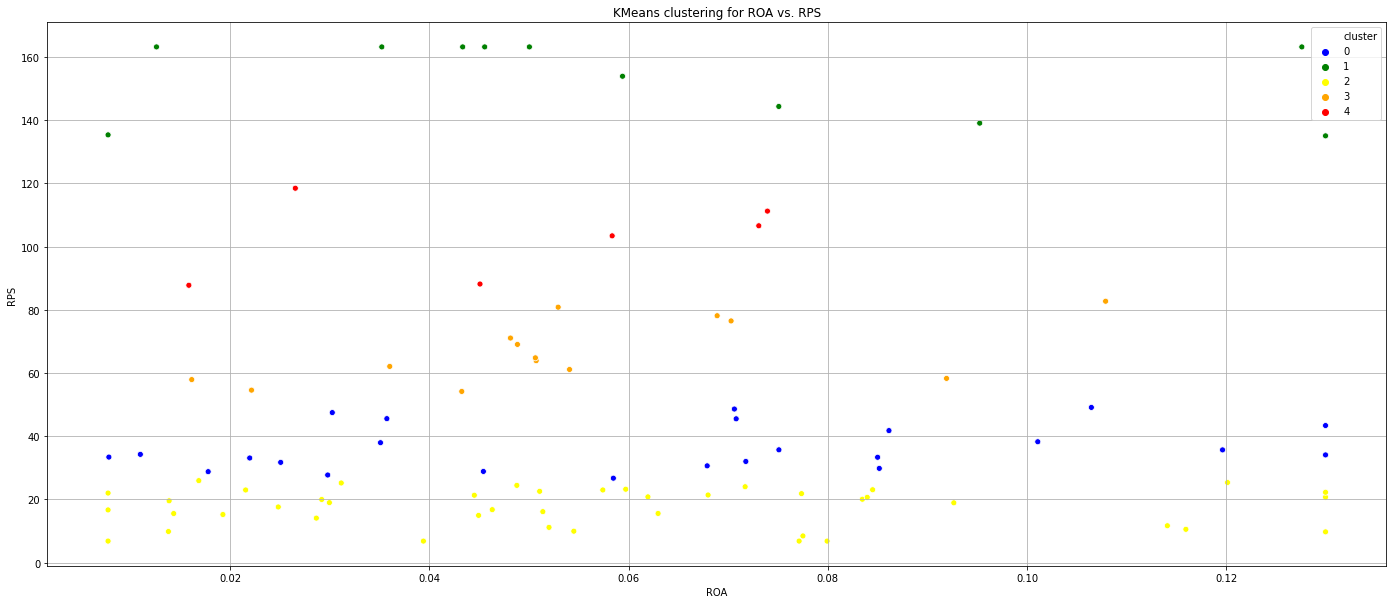

In [10]:
plt.figure(figsize = (24,10))
plt.grid(True)
plot = sns.scatterplot(x = df['ROA'], y = df['RPS'], hue = df_kmeans['cluster'].astype(int), palette = ['blue','green','yellow','orange','red'], data = df_kmeans)
plt.title("KMeans clustering for ROA vs. RPS")

In [11]:
clusters_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns = ['ROA', 'RPS'])
clusters_centers_df.head()

,ROA,RPS
0,0.063248,36.400625
1,0.061979,153.331091
2,0.055407,16.970022
3,0.054420,66.796357
4,0.048805,102.596333


In [12]:
clustering_result = pd.DataFrame(zip(y_kmeans, df.index), columns = ['Cluster', 'Company'])
clustering_result.set_index("Cluster").head()

,Company
Cluster,
0,SNPS
2,A
0,CBOE
2,HBAN
3,SJM


In [13]:
for cluster_num in list(clustering_result.set_index('Cluster').index.unique()):
    print(clustering_result.set_index('Cluster').loc[cluster_num].head())

        Company
Cluster        
0          SNPS
0          CBOE
0           XYL
0            BR
0           WST
        Company
Cluster        
2             A
2          HBAN
2          SBUX
2          ZION
2           GLW
        Company
Cluster        
3           SJM
3          PCAR
3           PGR
3          BIIB
3           PXD
        Company
Cluster        
4          SIVB
4           SWK
4           BLK
4            PH
4           LHX
        Company
Cluster        
1           MPC
1           CMG
1         GOOGL
1           CNC
1           ALL


In [14]:
clusters_centers_df['Count'] = clustering_result['Cluster'].value_counts().to_frame().rename(columns = {'Cluster': 'Count'})['Count']
clusters_centers_df.head()

,ROA,RPS,Count
0,0.063248,36.400625,24
1,0.061979,153.331091,11
2,0.055407,16.970022,45
3,0.054420,66.796357,14
4,0.048805,102.596333,6


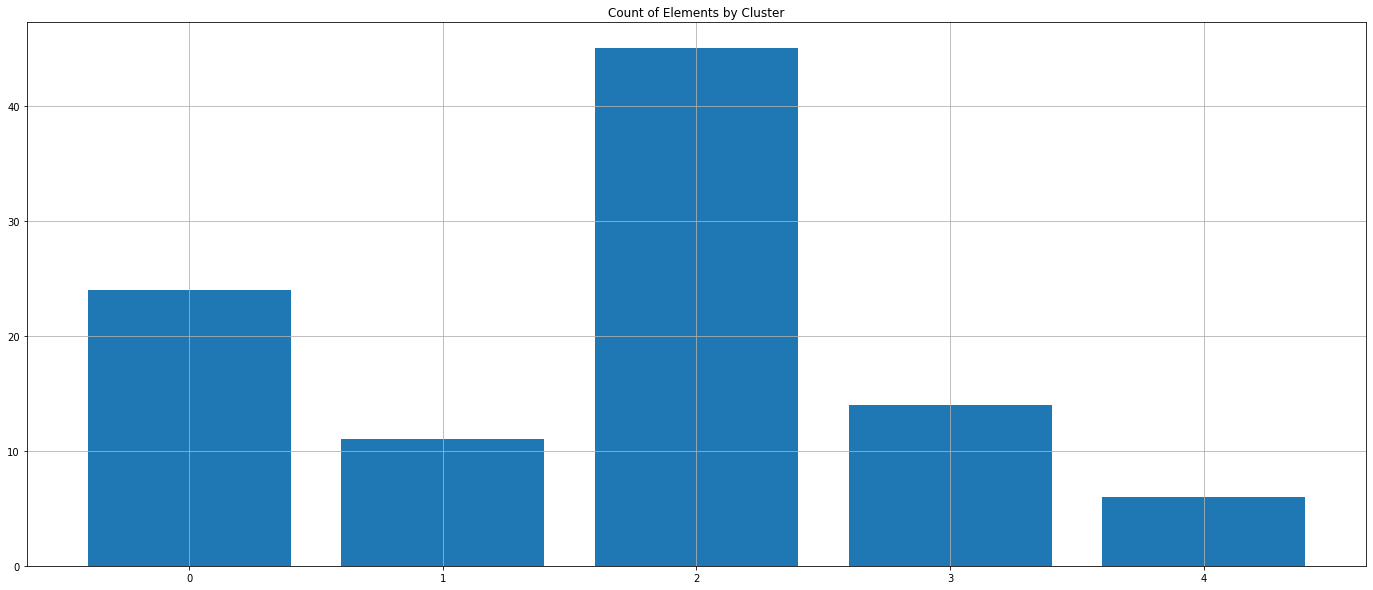

In [15]:
plt.figure(figsize = (24,10))
plt.bar(clusters_centers_df.index.values, clusters_centers_df['Count'])
plt.title("Count of Elements by Cluster")
plt.grid()
plt.show()

In [16]:
end = dt.date.today()
start = dt.date(end.year - 10, end.month, end.day)
df = yf.download(df.index.to_list(), start, end).dropna()
df.head()

[*********************100%***********************]  100 of 100 completed


Adj Close                                                         \
                    A        ABC        AEP        AES        AFL        AIZ   
Date                                                                           
2019-05-24  67.099228  77.633804  82.053131  15.414663  49.167660  96.530182   
2019-05-28  65.842842  77.835876  80.547562  15.265187  48.496456  96.357895   
2019-05-29  66.058769  75.391769  79.636787  15.003604  48.619354  96.568466   
2019-05-30  65.656342  75.362915  79.274338  14.844787  48.751701  96.482330   
2019-05-31  65.813393  74.920273  80.036430  14.760706  48.496456  95.678314   

                                                         ...   Volume  \
                  ALGN        ALK        ALL        AME  ...      TER   
Date                                                     ...            
2019-05-24  311.470001  59.601097  91.194839  83.068367  ...  2065600   
2019-05-28  304.809998  59.069912  89.983566  82.517792  ...  1804500   
2019-05-29  297.410004  58.302643  91.062363  81.986877  ...  2195800   
2019-05-30  296.679993  57.820641  91.214546  82.399803  ...  1508300   
2019-05-31  284.350006  57.250107  90.853088  80.512115  ...  2178500   

                                                                          \
                TPR     UHS      VTR      WEC     WRB     WST        XYL   
Date                                                                       
2019-05-24  5984300  547600  1189200  1327700  420800  154700   818500.0   
2019-05-28  9148500  666200  2364400  2229600  839600  141500   994100.0   
2019-05-29  4587700  691300  1430300  1540100  603000  161600  1023800.0   
2019-05-30  5787600  503700  1536300  1325800  346400  124400   359400.0   
2019-05-31  4355100  608800  1959100  1820800  563600  212200   800400.0   

                              
                ZBH     ZION  
Date                          
2019-05-24   586400  1468400  
2019-05-28   842000  3367100  
2019-05-29  1250600  1968000  
2019-05-30   628900  1291300  
2019-05-31  1381000  2510800  

[5 rows x 600 columns]

In [17]:
stock_count = 15
stock_count_by_cluster = pd.DataFrame(round(stock_count * clustering_result.groupby(by = 'Cluster').count()['Company'] / clustering_result.count()['Company'], 0))
stock_count_by_cluster

,Company
Cluster,
0,4.0
1,2.0
2,7.0
3,2.0
4,1.0
